# Transport Model using MT3DMS Problem 9 Example

This section is to recreate the example problems that were first described in the 1999 MT3DMS report, closely following [https://modflow6-examples.readthedocs.io/en/master/_notebooks/ex-gwt-mt3dms-p09.html](https://modflow6-examples.readthedocs.io/en/master/_notebooks/ex-gwt-mt3dms-p09.html).  

The source  above demonstrates that the MF6 result and MT3D result are comparable.

Ten example problems appear in the 1999 MT3DMS manual, starting on page 130. This notebook demonstrates example 9 from those ten examples.

:::{note}
Substantial rewrite, and some debugging to get the example to run on my computer.  A generic cut-and-paste from [https://modflow6-examples.readthedocs.io/en/master/_notebooks/ex-gwt-mt3dms-p09.html](https://modflow6-examples.readthedocs.io/en/master/_notebooks/ex-gwt-mt3dms-p09.html) is likely to be quite unsucessful.  I had to modify parts of the script for my machine (ie. to find the compiled binary).  And one object needed changing.  The example code at the link will probably work fine if your install is identical in terms of file paths as the GitHub source, and you have binaries in the correct locations. 

Herein the goal is simply to reverse engineer the workflow and plotting tools.  Later examples we will focus on actual modeling.
:::

:::{warning}
The next two code cells are specific to my machine, the reset wipes the lernel memory when it attempts to build the notebook for caching and subsequent typesetting.  The `warnings ignore` turns off a lot of deprecation warnings.  The online reference is funny enough to share

> You should just fix your code but just in case,

```
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
```

:::


In [32]:
%reset -f

In [33]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

:::{note}
The script generates a lot of output that are suppressed by a `;`  Comment the character out to re-enable full output (which is damn helpful for debugging the script!)
:::

## Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [34]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

:::{note}
The code block above loads various modules into the environment; they must exist and be loaded into the kernel - if not you get a warning "Module Not Found" and will have to install into the kernel (i.e. `pip -m install module`, or the `conda` equivalent
Filter warnings repeated to achieve "for sure ..." that the filter is applied.  By design the filter will not stop ERRORS, and warnings issued within functions will still display, but it will address one annoying deprecation error.
:::

### Define parameters

Define model units, parameters and other settings.

In [35]:
# Model units
length_units = "meters"
time_units = "seconds"

# Model parameters
nlay = 1  # Number of layers
nrow = 18  # Number of rows
ncol = 14  # Number of columns
delr = 100.0  # Column width ($m$)
delc = 100.0  # Row width ($m$)
delz = 10.0  # Layer thickness ($m$)
top = 0.0  # Top of the model ($m$)
prsity = 0.3  # Porosity
k1 = 1.474e-4  # Horiz. hyd. conductivity of medium grain material ($m/sec$)
k2 = 1.474e-7  # Horiz. hyd. conductivity of fine grain material ($m/sec$)
inj = 0.001  # Injection well rate ($m^3/sec$)
ext = -0.0189  # Extraction well pumping rate ($m^3/sec$)
al = 20.0  # Longitudinal dispersivity ($m$)
trpt = 0.2  # Ratio of horiz. transverse to longitudinal dispersivity ($m$)
perlen = 2.0  # Simulation time ($years$)

# Additional model input
hk = k1 * np.ones((nlay, nrow, ncol), dtype=float)
hk[:, 5:8, 1:8] = k2
laytyp = icelltype = 0

# Active model domain
ibound = np.ones((nlay, nrow, ncol), dtype=int)
ibound[0, 0, :] = -1
ibound[0, -1, :] = -1
idomain = np.ones((nlay, nrow, ncol), dtype=int)
icbund = 1

# Boundary conditions
# MF2K5 pumping info
qwell1 = 0.001
qwell2 = -0.0189
welspd = {0: [[0, 3, 6, qwell1], [0, 10, 6, qwell2]]}  # Well pumping info for MF2K5
cwell1 = 57.87
cwell0 = 0.0
spd = {
    0: [[0, 3, 6, cwell1, 2], [0, 10, 6, cwell0, 2]],
    1: [[0, 3, 6, cwell0, 2], [0, 10, 6, cwell0, 2]],
}  # Well info 4 MT3D
# MF6 pumping information
wellist_sp1 = []
#                   (k,  i, j),   flow,  conc
wellist_sp1.append([(0, 3, 6), qwell1, cwell1])  # Injection well
wellist_sp1.append([(0, 10, 6), qwell2, cwell0])  # Pumping well
#
wellist_sp2 = []
#                   (k,  i, j),   flow,  conc
wellist_sp2.append([(0, 3, 6), qwell1, cwell0])  # Injection well
wellist_sp2.append([(0, 10, 6), qwell2, cwell0])  # Pumping well
spd_mf6 = {0: wellist_sp1, 1: wellist_sp2}

# Transport related
sconc = 0.0
ath1 = al * trpt
dmcoef = 0.0  # m^2/s
# Time variables
perlen = [365.0 * 86400, 365.0 * 86400]
steady = [False, False]
nper = len(perlen)
nstp = [365, 365]
tsmult = [1.0, 1.0]
#
sconc = 0.0
c0 = 0.0
botm = [top - delz]
mixelm = -1

# Solver settings
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0
percel = 1.0  # HMOC parameters
itrack = 2
wd = 0.5
dceps = 1.0e-5
nplane = 0
npl = 0
nph = 16
npmin = 2
npmax = 32
dchmoc = 1.0e-3
nlsink = nplane
npsink = nph
nadvfd = 1

The code block above loads variables and constants to define the actual model.  We will focus on how to conceptualize later on.

## Model setup

Define functions to build models, write input files, and run the simulation.

**Groundwater Flow Package Build**

In [36]:
# Workspace and Executibles
#binary = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6"  # location on MY computer of the compiled modflow program
#workarea = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6-ex1" # location on MY computer to store files this example (directory must already exist)
#workarea = workspace # location on MY computer to store files this example (directory must already exist)

binary = "/home/sensei/mfplayground/modflow-python/mf6.4.1_linux/bin/mf6"  # location on AWS computer of the compiled modflow program
workarea = "/home/sensei/ce-5364-webroot/mfexperiments/mf6-ex1" # location on MY computer to store files this example (directory must already exist)

# Set Simulation Name(s)
name = "mt3d_ex09"
gwfname = "gwf-" + name
gwtname = "gwt-" + name

##### FLOPY Build simulation framework ####
sim = flopy.mf6.MFSimulation(
    sim_name="sim-" + name, exe_name=binary, version="mf6", sim_ws=workarea
)
####### CREATED "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mt3d_example9"

The code block above sets paths to the binary (in my case a compiled MODFLOW6 object located at `/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/`.   The binary was built using the `make` utility operating on the `makefile` contained in `~path_to_source/mf6.4.1_linux/make`

In [37]:
####### Instantiating MODFLOW 6 time discretization ########
tdis_rc = []
for i in range(nper):
    tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units);
## delete ";" in above line at end to show full output

The code block above sets the time stepping structure.  Units are supplied in the model constants already created. `perlen` is a list of period length in time units of a stress period. , `nstp` is a list of the number of time steps per period, tsmult is a list of time step multipliers.

In [38]:
####### Instantiating MODFLOW 6 groundwater flow model ########
# Set Model Name (using same base name as the simulation)
model_nam_file = "{}.nam".format(gwfname)
# create MODFLOW6 flow model framework
gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, save_flows=True, model_nam_file=model_nam_file);
## delete ";" in above line at end to show full output

The code block above sets prefix of the flow model file names.  

In [39]:
###### Instantiating MODFLOW 6 solver for flow model #######
# Set Iterative Model Solution (choose solver parameters)
# about IMS see: https://water.usgs.gov/nrp/gwsoftware/ModelMuse/Help/sms_sparse_matrix_solution_pac.htm
# using defaults see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.mf6.modflow.mfims.html
imsgwf = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="NONE",
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=rclose,
    linear_acceleration="CG",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    filename=f"{gwfname}.ims",
    )
sim.register_ims_package(imsgwf, [gwf.name]);
## delete ";" in above line at end to show full output

The code block above sets the iteration and solver parameters.  URL to documents is included in the comments.

In [40]:
###### Instantiating MODFLOW 6 discretization package ######
flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    filename=f"{gwfname}.dis",
    );
## delete ";" in above line at end to show full output

The code block above sets the spatial structure.  We must supply layers, rows, columns, and spacing between rows and columns (i.e. how big is a pixel).  Vertical spacing computed as 

$$\Delta z = \frac{\text{top}-\text{bottom}}{\text{number of layers}}$$

In [41]:
###### Instantiating MODFLOW 6 initial conditions package for flow model #######
strt = np.zeros((nlay, nrow, ncol), dtype=float)
strt[0, 0, :] = 250.0
xc = gwf.modelgrid.xcellcenters
for j in range(ncol):
    strt[0, -1, j] = 20.0 + (xc[-1, j] - xc[-1, 0]) * 2.5 / 100
flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic");
## delete ";" in above line at end to show full output

The code block above sets the initial conditions. The top row in this example is set to 250, the bottom row from 20 to 52.5 in steps of 2.5.  If there are other starting conditions either write code or read from a file, or hard-code the constants as needed.

In [42]:
# Instantiating MODFLOW 6 node-property flow package
flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=False,
    icelltype=icelltype,
    k=hk,
    k33=hk,
    save_specific_discharge=True,
    filename=f"{gwfname}.npf",
    );
## delete ";" in above line at end to show full output

The code block above sets the node-property data (its like the old BCF package).  Here we supply that we want to save sp. discharge (needed for transport), the k, and k33 values the same implies NOT unconfined sustem.

In [43]:
# Instantiate storage package
sto = flopy.mf6.ModflowGwfsto(gwf, ss=1.0e-05);
## delete ";" in above line at end to show full output

The code block above sets the storage properties for transient simulations.

In [44]:
# Instantiating MODFLOW 6 constant head package
# MF6 constant head boundaries:
chdspd = []
# Loop through the top & bottom sides.
for j in np.arange(ncol):
        #               l,  r, c,  head, conc
    chdspd.append([(0, 0, j), 250.0, 0.0])  # Top boundary
    hd = 20.0 + (xc[-1, j] - xc[-1, 0]) * 2.5 / 100
    chdspd.append([(0, 17, j), hd, 0.0])  # Bottom boundary
chdspd = {0: chdspd}

flopy.mf6.ModflowGwfchd(
    gwf,
    maxbound=len(chdspd),
    stress_period_data=chdspd,
    save_flows=False,
    auxiliary="CONCENTRATION",
    pname="CHD-1",
    filename=f"{gwfname}.chd",
    );
## delete ";" in above line at end to show full output

The code block above sets the constant head boundary conditions.

In [45]:
# Instantiate the wel package
flopy.mf6.ModflowGwfwel(
    gwf,
    print_input=True,
    print_flows=True,
    stress_period_data=spd_mf6,
    save_flows=False,
    auxiliary="CONCENTRATION",
    pname="WEL-1",
    filename=f"{gwfname}.wel",
    );
## delete ";" in above line at end to show full output

The code block above sets activates the well paclage

In [46]:
# Instantiating MODFLOW 6 output control package for flow model
flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{gwfname}.hds",
    budget_filerecord=f"{gwfname}.bud",
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    );
## delete ";" in above line at end to show full output

The code block above defines parts of output control.



**Transport Package Building**

In [47]:
###### Instantiating MODFLOW 6 groundwater transport package ##########
gwtname = "gwt-" + name
gwt = flopy.mf6.MFModel(
    sim,
    model_type="gwt6",
    modelname=gwtname,
    model_nam_file=f"{gwtname}.nam",
    )#;
## delete ";" in above line at end to show full output
gwt.name_file.save_flows = True

The code block above sets prefix of the transport model file names.  

In [48]:
# create iterative model solution and register the gwt model with it
imsgwt = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="NONE",
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=rclose,
    linear_acceleration="BICGSTAB",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    filename=f"{gwtname}.ims",
    )
sim.register_ims_package(imsgwt, [gwt.name]);
## delete ";" in above line at end to show full output

The code block above sets the iteration and solver parameters.  

In [49]:
###### Instantiating MODFLOW 6 transport discretization package #####
flopy.mf6.ModflowGwtdis(
    gwt,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    filename=f"{gwtname}.dis",
    );
## delete ";" in above line at end to show full output

The code block above sets the spatial structure.  We must supply layers, rows, columns, and spacing between rows and columns (i.e. how big is a pixel).  Vertical spacing computed as 

$$\Delta z = \frac{\text{top}-\text{bottom}}{\text{number of layers}}$$

Typically will be same as flow model.

In [50]:
# Instantiating MODFLOW 6 transport initial concentrations
flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic");
## delete ";" in above line at end to show full output

Initial conditions (concentration) for transport.

In [51]:
    # Instantiating MODFLOW 6 transport advection package
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv");
## delete ";" in above line at end to show full output

Advective transport methods.  In this example upwind formulation with Total Variation Diminishing (TVD) flux limiters. A TVD formulation is a numerical method designed to ensure that the computed solution to a transport equation does not exhibit non-physical oscillations or spurious oscillations, particularly near discontinuities or steep gradients. This flux limitation is crucial for maintaining the accuracy and stability of the numerical solution in simulations involving advective transport, such as contaminant transport in groundwater models.

Key points about TVD formulations:

- Purpose: TVD methods aim to prevent the introduction of oscillations or artifacts in the numerical solution that can arise from the discretization of the transport equation, especially in regions with sharp gradients or discontinuities.

- Techniques: TVD schemes use various strategies to achieve this, including modifying the standard discretization approaches, using flux limiters, or applying specific numerical flux functions that ensure the total variation of the solution is not increased.

- Applications: TVD methods are commonly used in computational fluid dynamics, meteorology, and environmental modeling where accurate representation of transport processes is essential. In groundwater modeling, TVD formulations help to ensure realistic simulation of contaminant transport and avoid numerical artifacts that could lead to incorrect predictions.

- Examples: Common TVD schemes include the TVD Runge-Kutta methods, TVD Lax-Wendroff schemes, and various other high-resolution schemes that incorporate flux limiters or other modifications to ensure total variation diminishing properties.

In [52]:
# Instantiating MODFLOW 6 transport dispersion package
if al != 0:
    flopy.mf6.ModflowGwtdsp(
        gwt,
        alh=al, # longitudinal
        ath1=ath1, # transverse
        filename=f"{gwtname}.dsp",
        );
## delete ";" in above line at end to show full output

This code iniatiates the dispersion method with Longitudinal dispersivity  $a_l = 20.0~m$ and the ratio of horizontal transverse to longitudinal dispersivity $trpt = 0.2$  In the above script $a_t = trpt \times a_l$

In [53]:
# Instantiating MODFLOW 6 transport mass storage package
flopy.mf6.ModflowGwtmst(
    gwt,
    porosity=prsity,
    first_order_decay=False,
    decay=None,
    decay_sorbed=None,
    sorption=None,
    bulk_density=None,
    distcoef=None,
    filename=f"{gwtname}.mst",
    );
## delete ";" in above line at end to show full output

Code block sets adsorbtion/desorbtion and 1st order decay terms if any.

In [54]:
# Instantiating MODFLOW 6 transport source-sink mixing package
sourcerecarray = [
    ("WEL-1", "AUX", "CONCENTRATION"),
    ("CHD-1", "AUX", "CONCENTRATION"),
    ]
flopy.mf6.ModflowGwtssm(
    gwt,
    sources=sourcerecarray,
    print_flows=True,
    filename=f"{gwtname}.ssm",
    );
## delete ";" in above line at end to show full output

Code above manages source/sink mixing terms.

In [55]:
# Instantiating MODFLOW 6 transport output control package
flopy.mf6.ModflowGwtoc(
    gwt,
    budget_filerecord=f"{gwtname}.cbc",
    concentration_filerecord=f"{gwtname}.ucn",
    concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    filename=f"{gwtname}.oc",
    );
## delete ";" in above line at end to show full output

Output control for transport

In [56]:
# Instantiating MODFLOW 6 flow-transport exchange mechanism
flopy.mf6.ModflowGwfgwt(
    sim,
    exgtype="GWF6-GWT6",
    exgmnamea=gwfname,
    exgmnameb=gwtname,
    filename=f"{name}.gwfgwt",
    );
## delete ";" in above line at end to show full output

Code above manages how flow (gwf) and transport (gwt) exchange information at each time step.

**Generate the Files**

In [57]:
sim.write_simulation(silent=True)

**Running the Model** 

In [58]:
#success, buff = sim.run_simulation(silent=False, report=True)#Verbose output
success, buff = sim.run_simulation(silent=True, report=True)#Suppress output
assert success, pformat(buff)

### Plotting results

Plotting model results.

:::{note}
A lot of reverse engineering to produce plots; am positive this is not the best way to make the plots, but was using the original example link as a go-by.
:::

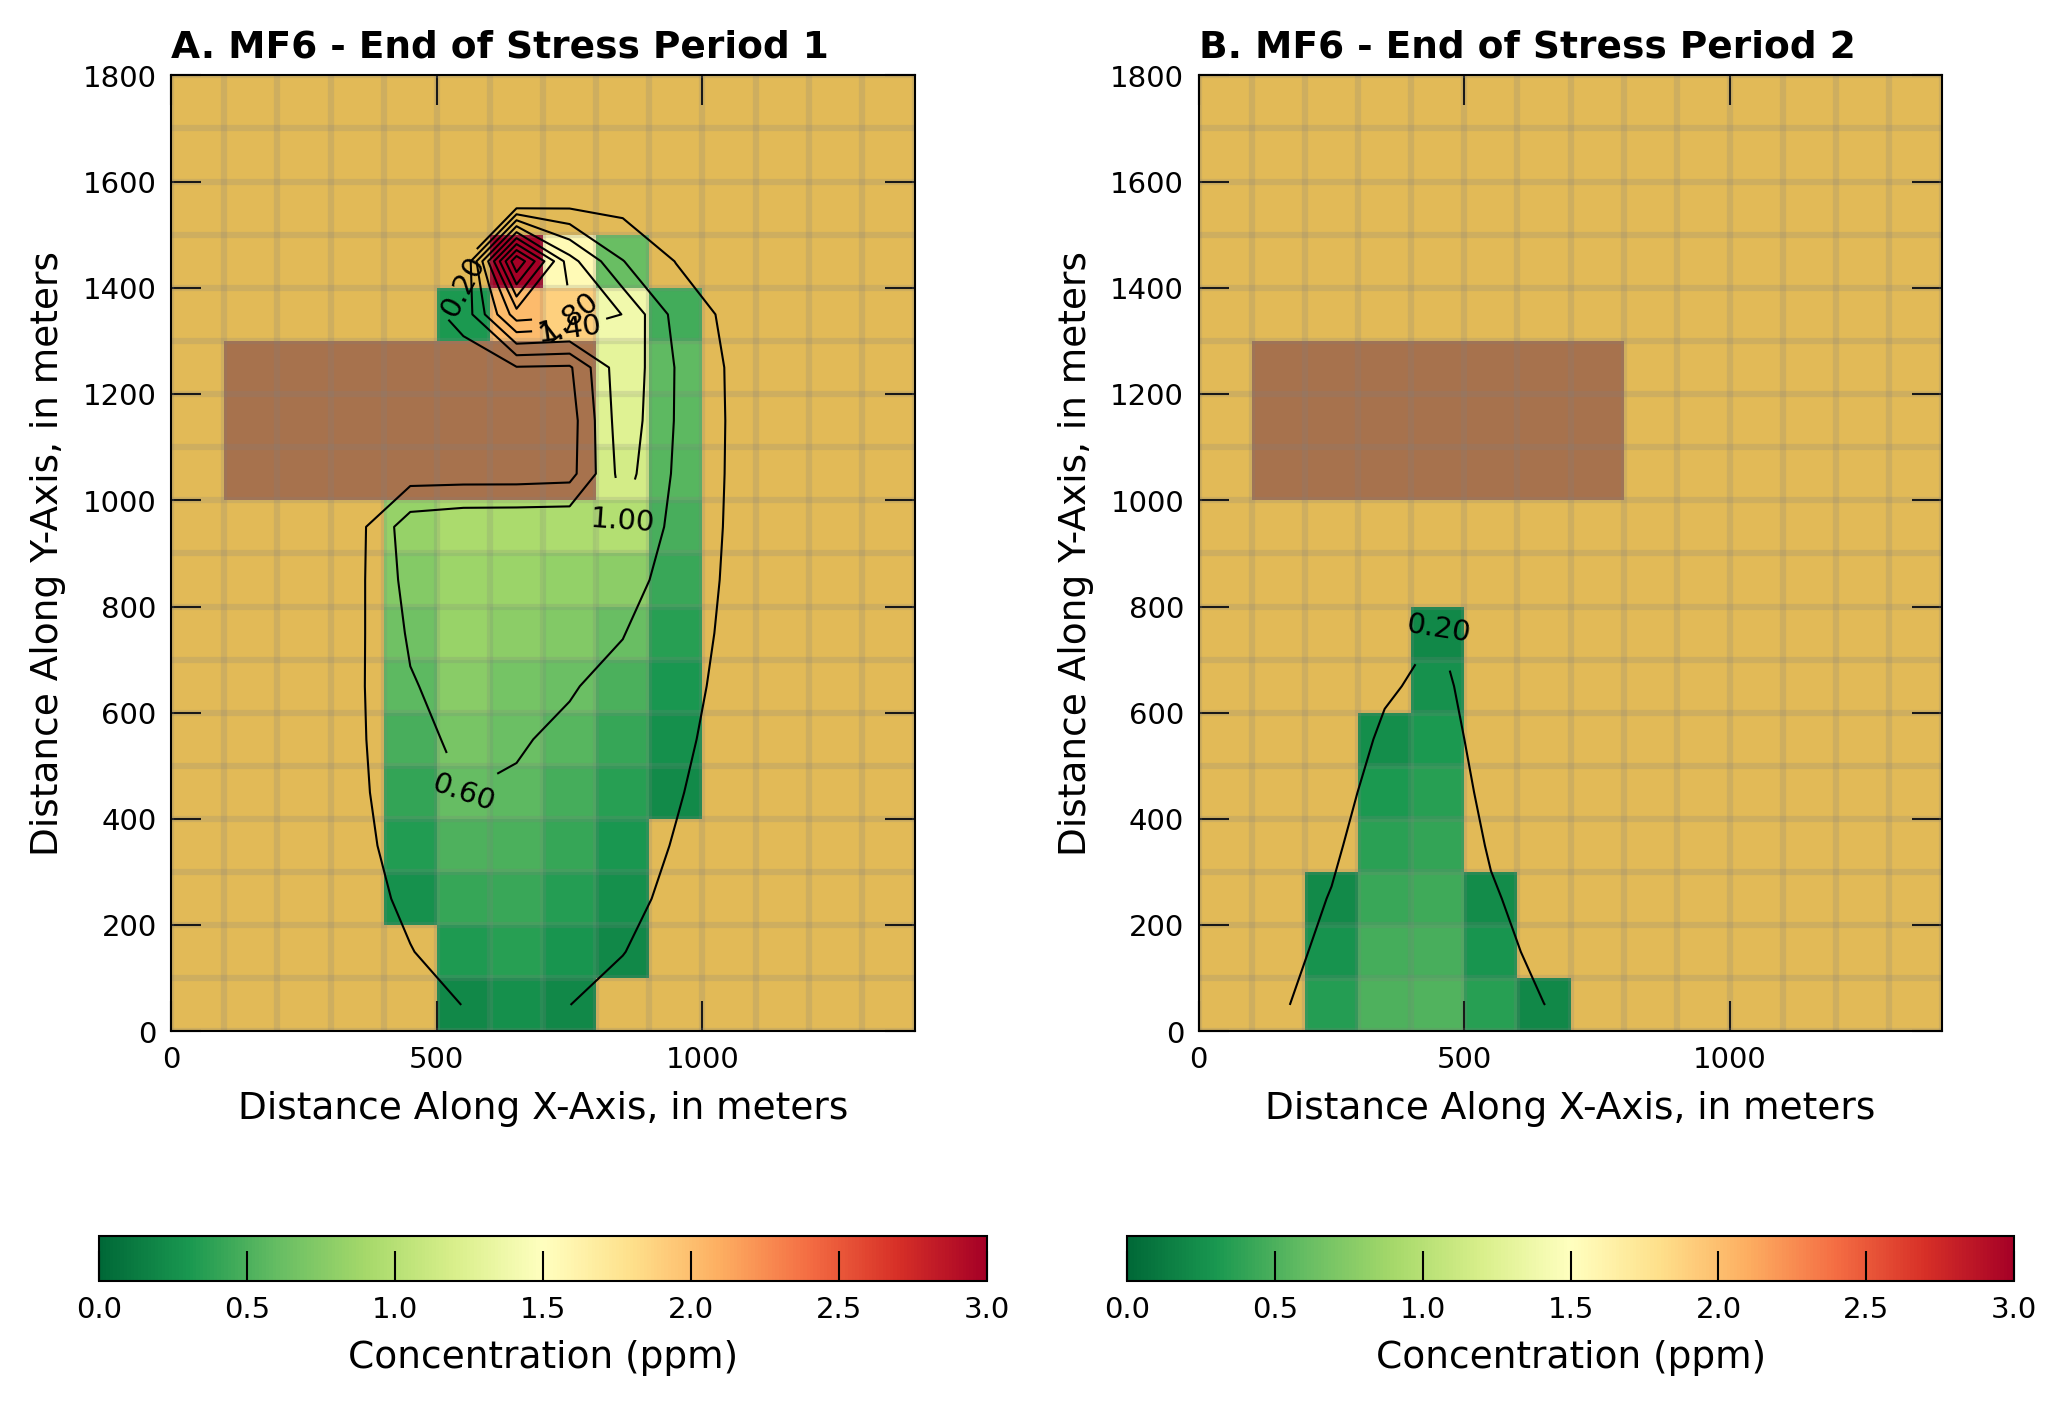

In [59]:
import copy
import matplotlib as mpl
# Figure properties
figure_size = (7, 5)
# Get the MF6 concentration output
gwt = sim.get_model(list(sim.model_names)[1])
ucnobj_mf6 = gwt.output.concentration()
conc_mf6 = ucnobj_mf6.get_alldata()


# Create figure for scenario
with styles.USGSPlot() as fs:
    sim_name = sim.name
    plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]
    levels = np.arange(0.2, 10, 0.4)
    stp_idx = 0  # 0-based (out of 2 possible stress periods)
# Plot after 8 years
    axWasNone = False
#    if ax is None:
    fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)
    axWasNone = True
    ax = fig.add_subplot(1, 2, 1, aspect="equal")
    cflood = np.ma.masked_less_equal(conc_mf6[stp_idx], 0.2)
    mm = flopy.plot.PlotMapView(ax=ax, model=gwf)
    cmap = copy.copy(mpl.cm.get_cmap("RdYlGn_r"))
    #cmap = plt.get_cmap('RdYlGn_r')
    cmap.set_bad(color='none')
    colors = ['saddlebrown', 'goldenrod']
    cmap = ListedColormap(colors)
    #mm.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.8, cmap = cmap)
    mm.plot_array(hk, alpha=0.5, cmap = cmap)
    mm.plot_ibound()
    mm.plot_grid(color=".5", alpha=0.2)
    cmap = copy.copy(mpl.cm.get_cmap("RdYlGn_r"))
    #cmap = plt.get_cmap('RdYlGn_r')
    cmap.set_bad(color='none')
    cs = mm.plot_array(cflood[0],  alpha=1.0, vmin=0, vmax=3, cmap = cmap)
# Add a colorbar to the plot
    cbar = plt.colorbar(cs, orientation='horizontal')  # Use orientation='horizontal' if preferred
    cbar.set_label('Concentration (ppm)')  # Replace with appropriate label for your data
    cs = mm.contour_array(conc_mf6[stp_idx], colors="k", levels=levels, linewidths=0.5)
    plt.clabel(cs, fmt='%.2f')
    plt.xlabel("Distance Along X-Axis, in meters")
    plt.ylabel("Distance Along Y-Axis, in meters")

    title = "MF6 - End of Stress Period " + str(stp_idx + 1)
# set idx
    idx = 0
    letter = chr(ord("@") + idx + 1)
    styles.heading(letter=letter, heading=title)
    
# second stress period
    stp_idx = 1  # 0-based (out of 2 possible stress periods)
    if axWasNone:
        ax = fig.add_subplot(1, 2, 2, aspect="equal",label = "subplot2")
    cflood = np.ma.masked_less_equal(conc_mf6[stp_idx], 0.2)
    mm = flopy.plot.PlotMapView(ax=ax, model=gwf)
    colors = ['saddlebrown', 'goldenrod']
    cmap = ListedColormap(colors)
    #mm.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.8, cmap = cmap)
    mm.plot_array(hk, alpha=0.5, cmap = cmap)
    mm.plot_ibound()
    mm.plot_grid(color=".5", alpha=0.2)
    cmap = copy.copy(mpl.cm.get_cmap("RdYlGn_r"))
    #cmap = plt.get_cmap('RdYlGn_r')
    cmap.set_bad(color='none')
    cs = mm.plot_array(cflood[0], alpha=1.0, vmin=0, vmax=3, cmap = cmap)
# Add a colorbar to the plot
    cbar = plt.colorbar(cs, orientation='horizontal')  # Use orientation='horizontal' if preferred
    cbar.set_label('Concentration (ppm)')  # Replace with appropriate label for your data
    cs = mm.contour_array(conc_mf6[stp_idx], colors="k", levels=levels, linewidths=0.5)
    plt.clabel(cs, fmt='%.2f')
    plt.xlabel("Distance Along X-Axis, in meters")
    plt.ylabel("Distance Along Y-Axis, in meters")

    title = "MF6 - End of Stress Period " + str(stp_idx + 1)
# set idx
    idx = 1
    letter = chr(ord("@") + idx + 1)
    styles.heading(letter=letter, heading=title)

In the figures above, the brown rectangle contained within the goldenrod rectangle represent two different horizontal hydraulic conductivities. The goldenrod color represents the conductivity of a medium grain material, $K_1 = 1.474\times 10^{-4}~\frac{m}{sec}$. The brown color represents theconductivity of a fine grain material, $K_2 = 1.474 \times 10^{-7}~\frac{m}{sec}$.

The plume "color map" is overlain on the material property map, and is set to opaque (not transparent).  The color ramp is and inverted GreenYellowRed.  High values render as red, lowest as green.

## Conclusions

Reverse engineered enough to be able to model reasonably complex situations.  The reader should experiment how to get specific discharge out of the model and plot as a "arrow plot" to show flow directions. 